In [85]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.patches import Patch
import plotly.subplots as sp


import warnings

warnings.filterwarnings("ignore")

import networkx as nx
import plotly.graph_objects as go
from collections import defaultdict

<small>

### 1. Load The Data

In [86]:
nodes_df = pd.read_csv("got_nodes.csv")
edges_df = pd.read_csv("got_edges.csv")

In [87]:
print(f"Total characters: {len(nodes_df)}")
print(f"Total relationships: {len(edges_df)}")

Total characters: 123
Total relationships: 500


<small>

### 2. Graph Construction

In [88]:
print("\n" + "=" * 80)
print("[3] CONSTRUCTING NETWORK GRAPH")
print("=" * 80)

# Create the graph
G = nx.Graph()

# Add nodes with attributes
for idx, row in nodes_df.iterrows():
    G.add_node(row["name"], house=row["house"], color=row["color"])

# Add edges with weights
for idx, row in edges_df.iterrows():
    G.add_edge(row["source"], row["target"], weight=row["Weight"])

print(f"Graph created successfully!")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Graph type: {'Directed' if G.is_directed() else 'Undirected'}")


[3] CONSTRUCTING NETWORK GRAPH
Graph created successfully!
Nodes: 123
Edges: 500
Graph type: Undirected


<small>

### 3. Network Metrices Calculation

In [89]:
# Calculate basic network metrics
density = nx.density(G)
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
num_components = nx.number_connected_components(G)

print(f"\n--- Basic Network Statistics ---")
print(f"Network Density: {density:.3f}")
print(f"Average Degree: {avg_degree:.2f}")
print(f"Number of Connected Components: {num_components}")


--- Basic Network Statistics ---
Network Density: 0.067
Average Degree: 8.13
Number of Connected Components: 1


In [90]:
# Get largest connected component for additional metrics
if num_components > 1:
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc).copy()
    if len(largest_cc) > 1:
        diameter = nx.diameter(G_largest)
        print(f"Network Diameter (largest component): {diameter}")
else:
    diameter = nx.diameter(G)
    print(f"Network Diameter: {diameter}")

Network Diameter: 7


<small>

### 4. Degree Centrality Analysis

In [91]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
degrees = dict(G.degree())
weighted_degrees = {}

In [92]:
# Calculate weighted degree (sum of edge weights)
for node in G.nodes():
    weighted_degree = sum(
        [G[node][neighbor]["weight"] for neighbor in G.neighbors(node)]
    )
    weighted_degrees[node] = weighted_degree

In [93]:
# Create comprehensive degree dataframe
degree_analysis = pd.DataFrame(
    {
        "Character": list(degrees.keys()),
        "Degree": list(degrees.values()),
        "Degree_Centrality": [degree_centrality[node] for node in degrees.keys()],
        "Weighted_Degree": [weighted_degrees[node] for node in degrees.keys()],
        "House": [G.nodes[node]["house"] for node in degrees.keys()],
    }
)

In [94]:
# Sort by degree
degree_analysis = degree_analysis.sort_values("Degree", ascending=False)

print("\n--- Character Degree Analysis ---")
print(degree_analysis.to_string(index=False))


--- Character Degree Analysis ---
        Character  Degree  Degree_Centrality  Weighted_Degree     House
             robb      31           0.254098              375     stark
            tywin      28           0.229508              364 lannister
           tyrion      25           0.204918              653 lannister
          catelyn      22           0.180328              230     stark
          joffrey      21           0.172131              279 lannister
           cersei      20           0.163934              354 lannister
              jon      19           0.155738              323     stark
            sansa      19           0.155738              363     stark
     roose_bolton      17           0.139344              150    bolton
              sam      17           0.139344              226     other
             bran      17           0.139344              292     stark
             arya      16           0.131148              288     stark
              ned      16    

In [95]:
# Find most connected characters
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop 5 Most Connected Characters:")
for i, (char, deg) in enumerate(sorted_degrees[:5], 1):
    print(
        f"{i}. {char.capitalize()}: {deg} connections (Weighted: {weighted_degrees[char]})"
    )


Top 5 Most Connected Characters:
1. Robb: 31 connections (Weighted: 375)
2. Tywin: 28 connections (Weighted: 364)
3. Tyrion: 25 connections (Weighted: 653)
4. Catelyn: 22 connections (Weighted: 230)
5. Joffrey: 21 connections (Weighted: 279)


<small>

### 5. Interaction Strength Analysis

In [96]:
edges_df.columns

Index(['source', 'target', 'Weight'], dtype='object')

In [97]:
# Analyze edge weights
weights = np.array(edges_df["Weight"].values)
total_weight = weights.sum()
mean_weight = np.mean(weights)
median_weight = np.median(weights)
std_weight = np.std(weights)

In [98]:
print(f"\n--- Weight Statistics ---")
print(f"Total Weight (sum of all interactions): {total_weight}")
print(f"Average Weight: {mean_weight:.2f}")
print(f"Median Weight: {median_weight:.2f}")
print(f"Standard Deviation: {std_weight:.2f}")
print(
    f"Min Weight: {weights.min()} ({edges_df.loc[edges_df['Weight'].idxmin(), 'source']}-{edges_df.loc[edges_df['Weight'].idxmin(), 'target']})"
)
print(
    f"Max Weight: {weights.max()} ({edges_df.loc[edges_df['Weight'].idxmax(), 'source']}-{edges_df.loc[edges_df['Weight'].idxmax(), 'target']})"
)


--- Weight Statistics ---
Total Weight (sum of all interactions): 5960
Average Weight: 11.92
Median Weight: 4.00
Standard Deviation: 19.07
Min Weight: 2 (aegon-davos)
Max Weight: 159 (jon-ygritte)


In [99]:
# Analyze top interactions
top_interactions = edges_df.nlargest(5, "Weight").copy()
top_interactions["percentage"] = (
    top_interactions["Weight"] / total_weight * 100
).round(1)

print(f"\n--- Top 5 Interactions ---")
print(top_interactions.to_string(index=False))


--- Top 5 Interactions ---
 source  target  Weight  percentage
    jon ygritte     159         2.7
brienne   jaime     127         2.1
 tyrion   tywin     115         1.9
 ramsay   theon     114         1.9
 cersei  tyrion      95         1.6


<small>

### 6. House-Base Analysis

In [100]:
houses = nodes_df["house"].unique()
house_stats = {}

In [101]:
for house in houses:
    members = nodes_df[nodes_df["house"] == house]["name"].tolist()
    member_names = [m.capitalize() for m in members]

    # Calculate interactions within and outside house
    internal_interactions = 0
    external_interactions = 0
    internal_weight = 0
    external_weight = 0

    for idx, row in edges_df.iterrows():
        source_house = nodes_df[nodes_df["name"] == row["source"]]["house"].values
        target_house = nodes_df[nodes_df["name"] == row["target"]]["house"].values

        if len(source_house) > 0 and len(target_house) > 0:
            if source_house[0] == house or target_house[0] == house:
                if source_house[0] == target_house[0]:
                    internal_interactions += 1
                    internal_weight += row["Weight"]
                else:
                    external_interactions += 1
                    external_weight += row["Weight"]

    total_weight_house = internal_weight + external_weight

    house_stats[house] = {
        "members": member_names,
        "count": len(members),
        "internal_interactions": internal_interactions,
        "external_interactions": external_interactions,
        "internal_weight": internal_weight,
        "external_weight": external_weight,
        "total_weight": total_weight_house,
        "avg_weight": (
            total_weight_house / (internal_interactions + external_interactions)
            if (internal_interactions + external_interactions) > 0
            else 0
        ),
    }

In [102]:
# Print house analysis
for house, stats in house_stats.items():
    print(f"\n--- House {house.upper()} ---")
    print(f"Members ({stats['count']}): {', '.join(stats['members'])}")
    print(f"Internal Interactions: {stats['internal_interactions']}")
    print(f"External Interactions: {stats['external_interactions']}")
    print(f"Total Interaction Weight: {stats['total_weight']}")
    print(f"Average Weight: {stats['avg_weight']:.2f}")


--- House STARK ---
Members (11): Jon, Robb, Sansa, Arya, Bran, Catelyn, Talisa, Ned, Brandon_stark, Rickon, Maester_luwin
Internal Interactions: 21
External Interactions: 126
Total Interaction Weight: 1934
Average Weight: 13.16

--- House OTHER ---
Members (76): Brienne, Ramsay, Gilly, Davos, Shae, Bronn, Barristan, Kraznys_mo_nakloz, Melisandre, Edmure, Rickard_karstark, Daario, Littlefinger, Podrick, Meera, Orell, Tormund, Beric, Jojen, Brynden, Anguy, Ros, Hodor, Jeor, Craster, Grenn, Hound, Osha, Mance, Jorah, Mero, Rast, Grey_worm, Meryn_trant, Little_sam, Black_walder, Farmer, Roslin, Hot_pie, Hoster, Pyp, Randyll, Greizhen, Joyeuse, Lord_of_bones, Lothar, Marei, Sorcerer, Taryn_mant, High_septon, Merry, Mountain, Boros, Dareon, Desmond, Frey_septon, Ilyn_payne, Karl_tanner, Lysa, Qhorin_halfhand, Rylene, Salladhor, Ygritte, Sam, Thoros, Varys, Walder, Radzai_mo_eraz, Prendahl, Olyvar, Selwyn, Mycah, Drogo, Hobb, Matthos, Eldrick
Internal Interactions: 152
External Interactions

<small>

### 7. Character-Level Insights

In [103]:
# Analyze top characters
top_chars = degree_analysis.head(5)

print(f"\nTop 5 Most Influential Characters:\n")
for idx, row in top_chars.iterrows():
    char = row["Character"]
    house = row["House"]
    degree = row["Degree"]
    weighted_deg = row["Weighted_Degree"]

    # Find connections for this character
    connections = list(G.neighbors(char))
    connection_names = [c.capitalize() for c in connections]

    print(f"{char.upper()} ({house.upper()})")
    print(f"  - Connections: {degree}")
    print(f"  - Weighted Degree: {weighted_deg}")
    if connections:
        print(f"  - Connected to: {', '.join(connection_names)}")
    print()


Top 5 Most Influential Characters:

ROBB (STARK)
  - Connections: 31
  - Weighted Degree: 375
  - Connected to: Talisa, Catelyn, Edmure, Rickard_karstark, Walder, Brynden, Roose_bolton, Tywin, Black_walder, Roslin, Theon, Hoster, Sansa, Bran, Joyeuse, Jaime, Joffrey, Lothar, Mountain, Ned, Qyburn, Ramsay, Stannis, Tyrion, Arya, Balon, Davos, Hound, Martyn, Rickon, Varys

TYWIN (LANNISTER)
  - Connections: 28
  - Weighted Degree: 364
  - Connected to: Tyrion, Cersei, Joffrey, Olenna, Jaime, Sansa, Varys, Loras, Robb, Roose_bolton, Pycelle, Littlefinger, Locke, Margaery, Joanna, Stannis, Bronn, Catelyn, Edmure, Gendry, High_septon, Lysa, Mountain, Qyburn, Renly, Robert, Shae, Walder

TYRION (LANNISTER)
  - Connections: 25
  - Weighted Degree: 653
  - Connected to: Tywin, Cersei, Sansa, Shae, Bronn, Podrick, Olenna, Littlefinger, Joffrey, Varys, Loras, Meryn_trant, Pycelle, Margaery, Jaime, Marei, Taryn_mant, Catelyn, Robb, Ros, Sorcerer, Desmond, High_septon, Ned, Walder

CATELYN (STARK

<small>

### 8. Centrality Measure

In [104]:
# Betweenness Centrality (if network is connected)
if nx.is_connected(G):
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    centrality_df = pd.DataFrame(
        {
            "Character": list(betweenness.keys()),
            "Betweenness": list(betweenness.values()),
            "Closeness": list(closeness.values()),
            "Eigenvector": list(eigenvector.values()),
            "Degree": [degree_centrality[node] for node in betweenness.keys()],
        }
    )

    centrality_df = centrality_df.sort_values("Betweenness", ascending=False)

    print("\n--- Centrality Measures (Top 5) ---")
    print(centrality_df.head().to_string(index=False))
else:
    print("\nNetwork is not connected - some centrality measures may not be meaningful")
    # For disconnected graph, calculate for largest component
    largest_cc = max(nx.connected_components(G), key=len)
    G_sub = G.subgraph(largest_cc)

    if len(largest_cc) > 1:
        betweenness_sub = nx.betweenness_centrality(G_sub)
        closeness_sub = nx.closeness_centrality(G_sub)

        print(f"\nCentrality measures for largest component ({len(largest_cc)} nodes):")
        print("Top characters by betweenness centrality:")
        sorted_between = sorted(
            betweenness_sub.items(), key=lambda x: x[1], reverse=True
        )
        for char, val in sorted_between[:5]:
            print(f"  {char.capitalize()}: {val:.3f}")


--- Centrality Measures (Top 5) ---
Character  Betweenness  Closeness  Eigenvector   Degree
     robb     0.240725   0.478431     0.251117 0.254098
      ned     0.176474   0.455224     0.145821 0.131148
   robert     0.162445   0.394822     0.078465 0.098361
     bran     0.149062   0.413559     0.075051 0.139344
      jon     0.136747   0.391026     0.056713 0.155738


<small>

### 9. Visualization

Drawing edges...
Drawing nodes...
Drawing labels...


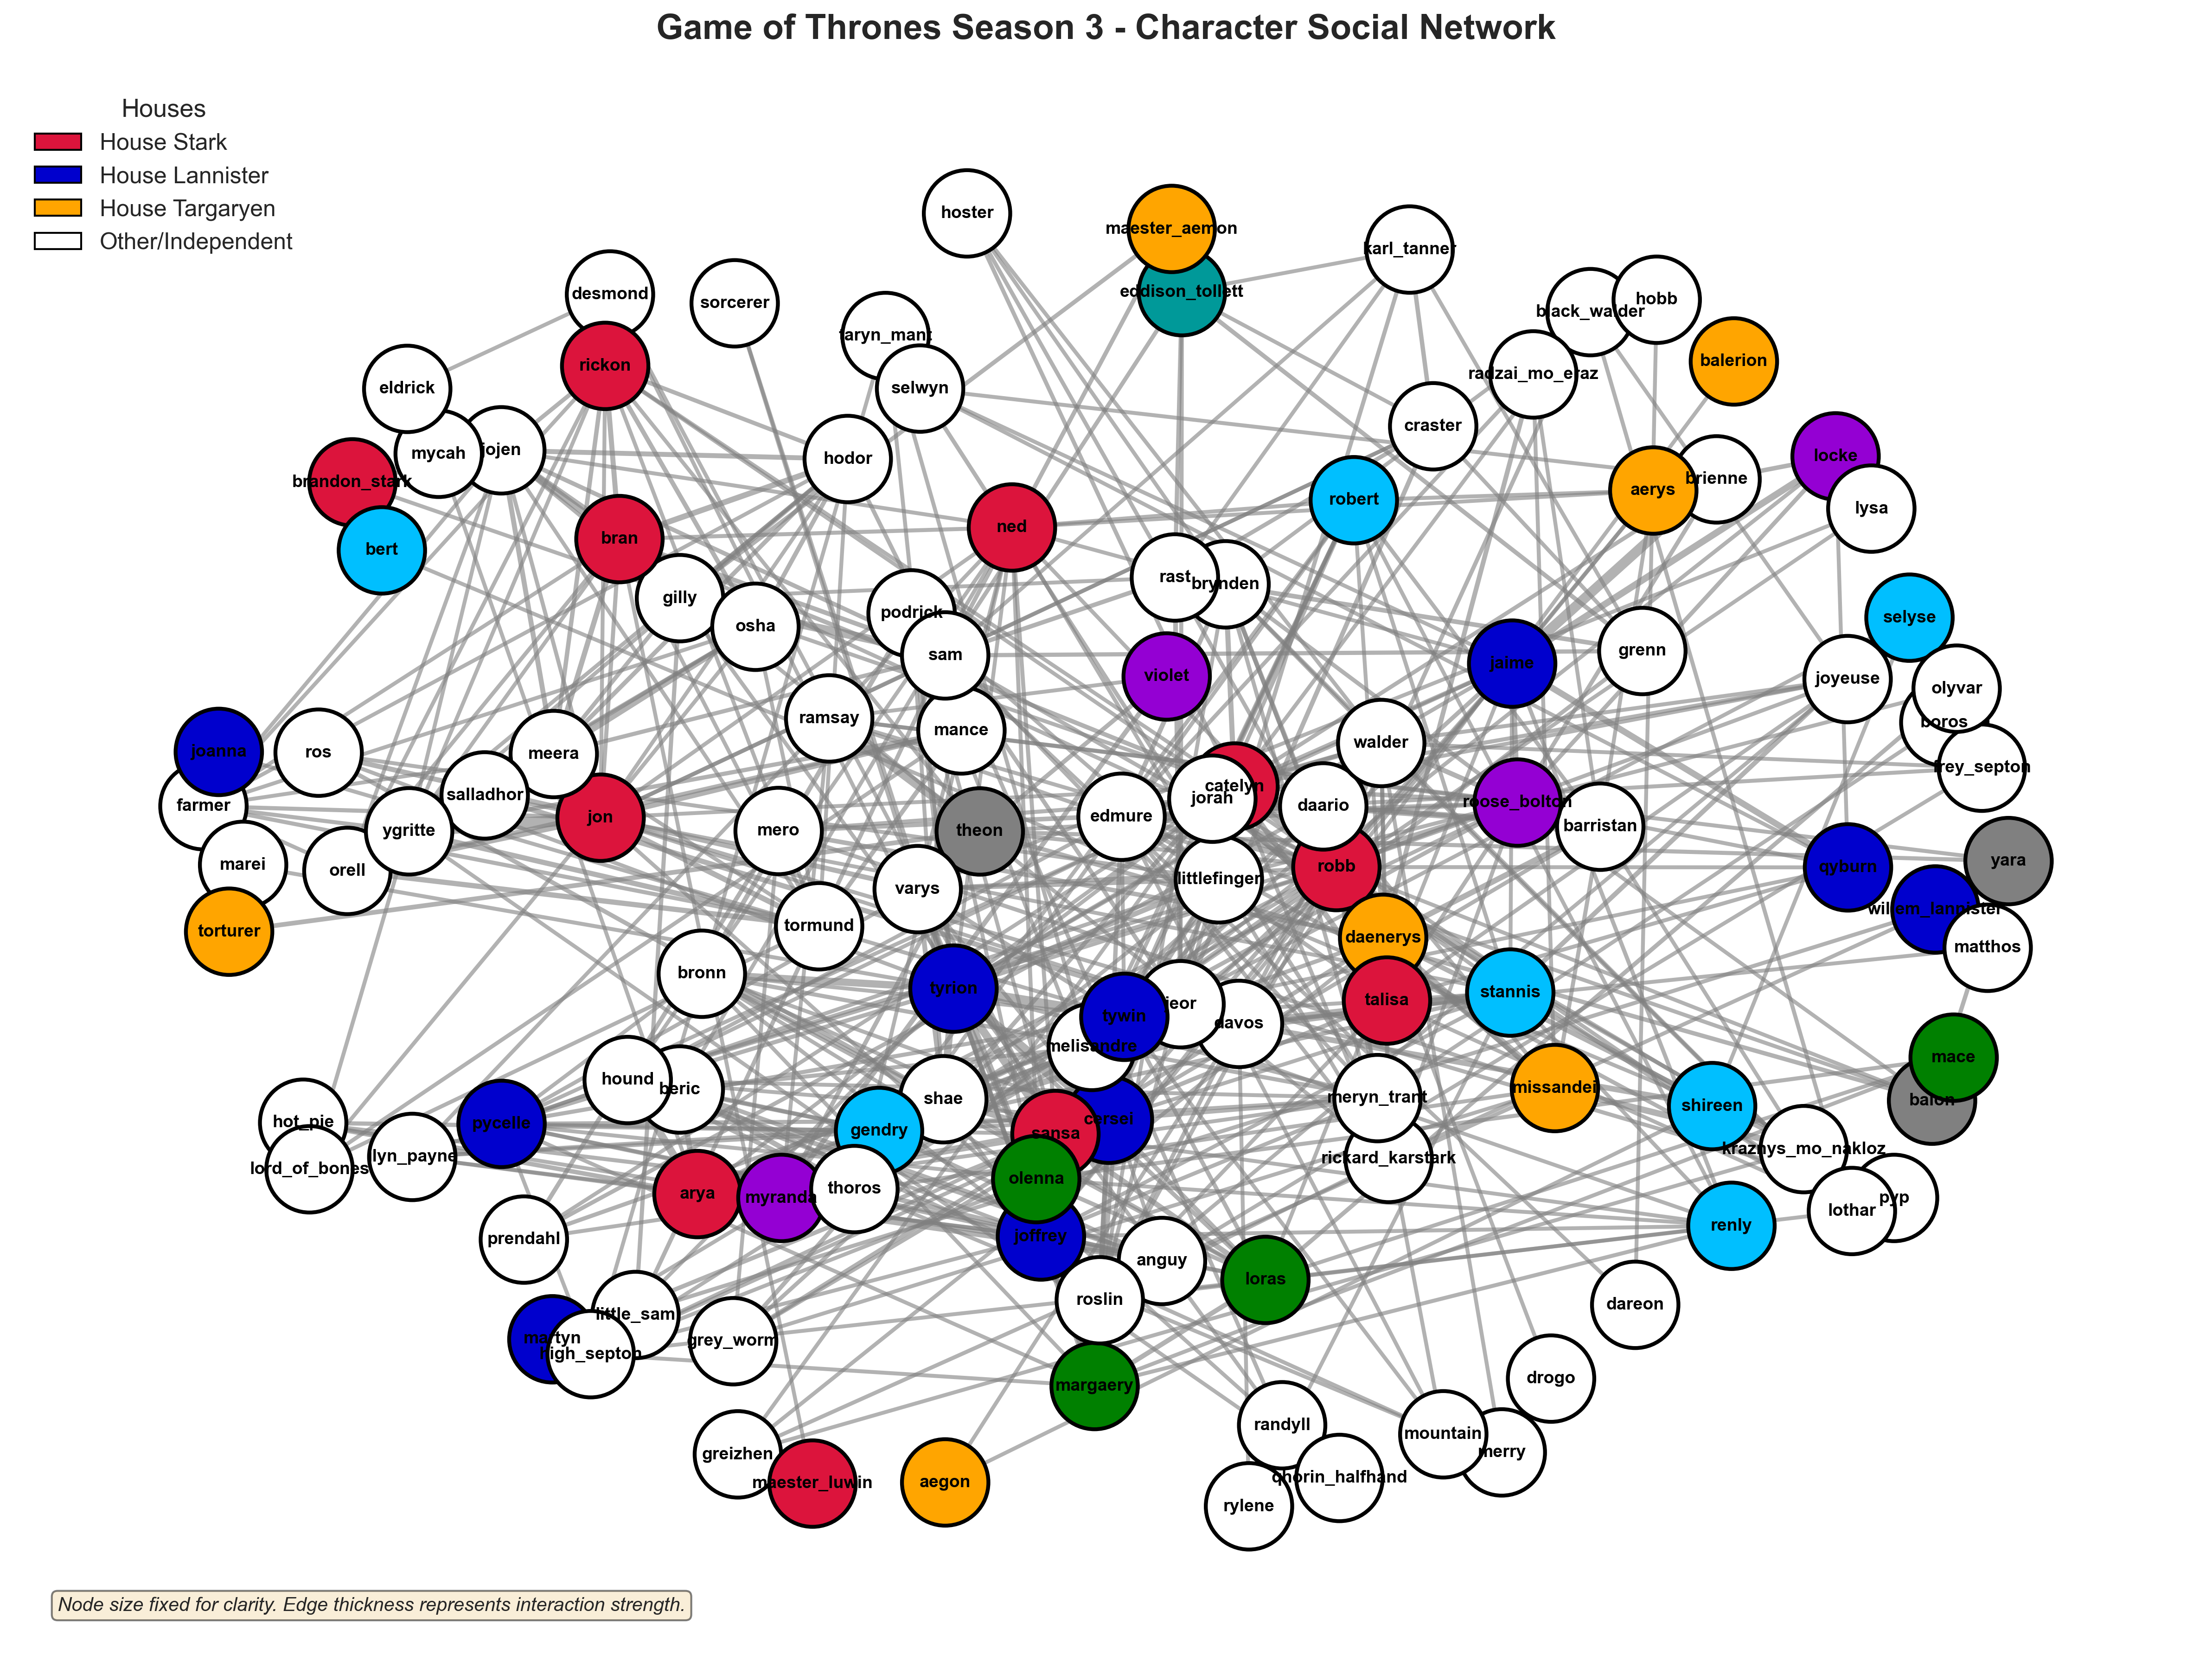

In [105]:
# Create figure with high resolution
fig, ax = plt.subplots(figsize=(16, 12), dpi=300)

# Generate layout for the graph
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Get node colors from graph attributes
node_colors = [G.nodes[node]["color"] for node in G.nodes()]

# Get edge weights for visualization
edges = G.edges()
weights = np.array([G[u][v]["weight"] for u, v in edges])

# Normalize weights for line width (range 2-6)
max_weight = weights.max()
min_weight = weights.min()
widths = [2 + 4 * ((w - min_weight) / (max_weight - min_weight)) for w in weights]

print("Drawing edges...")
# Draw edges with varying thickness
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.6, edge_color="gray", ax=ax)

print("Drawing nodes...")
# Draw nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=2000,
    edgecolors="black",
    linewidths=2,
    ax=ax,
)

print("Drawing labels...")
# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold", ax=ax)

# Create legend
legend_elements = [
    Patch(facecolor="#DC143C", edgecolor="black", label="House Stark"),
    Patch(facecolor="#0000CD", edgecolor="black", label="House Lannister"),
    Patch(facecolor="#FFA500", edgecolor="black", label="House Targaryen"),
    Patch(facecolor="#FFFFFF", edgecolor="black", label="Other/Independent"),
]
ax.legend(
    handles=legend_elements,
    loc="upper left",
    fontsize=12,
    title="Houses",
    title_fontsize=13,
    framealpha=0.95,
)

# Add title and labels
ax.set_title(
    "Game of Thrones Season 3 - Character Social Network",
    fontsize=18,
    fontweight="bold",
    pad=20,
)
ax.text(
    0.02,
    0.02,
    "Node size fixed for clarity. Edge thickness represents interaction strength.",
    transform=ax.transAxes,
    fontsize=10,
    style="italic",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

ax.axis("off")
plt.tight_layout()
plt.show()

In [106]:
# Save figure
plt.savefig("got_network_graph.png", dpi=300, bbox_inches="tight", facecolor="white")

<Figure size 640x480 with 0 Axes>

In [107]:
# Generate layout
pos = nx.spring_layout(G, k=2, iterations=80, seed=42)

# Prepare edge traces (smooth + lighter)
edge_x = []
edge_y = []
edge_text = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

    weight = G[edge[0]][edge[1]]["weight"]
    edge_text.append(
        f"{edge[0].capitalize()} — {edge[1].capitalize()}<br>Interactions: {int(weight)}"
    )

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode="lines",
    line=dict(width=1.2, color="rgba(150,150,150,0.45)"),
    hoverinfo="none",
    showlegend=False,
)

# Modern House Colors
house_colors_map = {
    "stark": "#E63946",  # New modern red
    "lannister": "#1D3557",  # Rich deep navy
    "targaryen": "#FF9F1C",  # Warm premium orange
    "other": "#A8A8A8",
}

# Prepare node traces
node_traces = {}
for house in nodes_df["house"].unique():
    house_nodes = [node for node in G.nodes() if G.nodes[node]["house"] == house]

    node_x = [pos[node][0] for node in house_nodes]
    node_y = [pos[node][1] for node in house_nodes]

    node_text = [
        f"<b>{node.capitalize()}</b><br>"
        f"House: {G.nodes[node]['house'].capitalize()}<br>"
        f"Connections: {G.degree(node)}<br>"
        f"Weighted Degree: {weighted_degrees[node]:.2f}"
        for node in house_nodes
    ]

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers+text",
        text=[n.capitalize() for n in house_nodes],
        textposition="top center",
        name=house.capitalize(),
        hovertext=node_text,
        hoverinfo="text",
        marker=dict(
            size=[max(8, G.degree(node) * 1.7) for node in house_nodes],
            color=house_colors_map.get(house, "#CCCCCC"),
            opacity=0.95,
            line=dict(width=3, color="white"),
            symbol="circle",
        ),
    )
    node_traces[house] = node_trace

# Build figure
fig = go.Figure(data=[edge_trace] + list(node_traces.values()))

fig.update_layout(
    title=dict(
        text="🔥 Game of Thrones — Season 3 Social Network (Interactive)",
        x=0.5,
        font=dict(size=24, family="Arial Black"),
    ),
    hovermode="closest",
    showlegend=True,
    height=850,
    plot_bgcolor="#F0F2F5",
    paper_bgcolor="#FFFFFF",
    margin=dict(l=20, r=20, t=60, b=20),
    # Hide axes completely
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    # Beautiful modern legend
    legend=dict(
        bgcolor="rgba(255,255,255,0.85)",
        bordercolor="black",
        borderwidth=1,
        x=0.02,
        y=0.98,
        font=dict(size=14),
    ),
    # Soft animation for improved UI
    transition=dict(duration=600, easing="cubic-in-out"),
)

# Add subtle glowing shadow effect
fig.update_traces(
    selector=dict(mode="markers+text"),
    marker=dict(showscale=False),
)

fig.show()

In [108]:
fig.write_html("got_interactive_network.html")

In [109]:
# 1. Top Characters Chart
fig1 = sp.make_subplots(rows=1, cols=1, specs=[[{"type": "bar"}]])

degree_sorted = degree_analysis.sort_values("Weighted_Degree", ascending=True).tail(15)

fig1.add_trace(
    go.Bar(
        y=degree_sorted["Character"].str.capitalize(),
        x=degree_sorted["Weighted_Degree"],
        orientation="h",
        marker=dict(
            color=degree_sorted["Weighted_Degree"],
            colorscale="Reds",
            showscale=True,
            colorbar=dict(title="Weighted Degree"),
        ),
        text=degree_sorted["Weighted_Degree"].astype(int),
        textposition="outside",
        hovertemplate="<b>%{y}</b><br>Influence: %{x}<extra></extra>",
    )
)

fig1.update_layout(
    title="Top 15 Most Influential Characters",
    xaxis_title="Weighted Degree (Interaction Strength)",
    yaxis_title="Character",
    height=600,
    showlegend=False,
    template="plotly_white",
    font=dict(size=12),
    margin=dict(l=150),
)
fig1.show()

In [110]:
# House counts
house_counts = nodes_df["house"].value_counts()

# Enhanced color palette (vibrant + modern)
house_colors_map = {
    "stark": "#E63946",  # strong red
    "lannister": "#1D3557",  # deep blue
    "targaryen": "#FF9F1C",  # warm orange
    "other": "#A8A8A8",  # soft grey
}

# Build enhanced chart
fig2 = go.Figure(
    data=[
        go.Pie(
            labels=[h.capitalize() for h in house_counts.index],
            values=house_counts.values,
            hole=0.45,  # makes it a donut chart
            marker=dict(
                colors=[house_colors_map.get(h, "#A8A8A8") for h in house_counts.index],
                line=dict(color="white", width=3),  # thicker borders
            ),
            textinfo="label+percent",
            textposition="inside",
            pull=[
                0.05 if i == house_counts.idxmax() else 0 for i in house_counts.index
            ],
            # Highlight the biggest house
            hovertemplate="<b>%{label}</b><br>Count: %{value}<br>%{percent}<extra></extra>",
        )
    ]
)

fig2.update_layout(
    title=dict(
        text="<b>Character Distribution by House</b>",
        x=0.5,
        y=0.95,
        font=dict(size=24, family="Arial Black"),
    ),
    height=650,
    template="plotly_white",
    font=dict(size=13, family="Segoe UI"),
    annotations=[
        dict(
            text="Houses",
            x=0.5,
            y=0.5,
            font_size=22,
            font_family="Arial Black",
            showarrow=False,
        )
    ],
)

# Smooth load animation
fig2.update_traces(sort=False, direction="clockwise")
fig2.update_layout(transition=dict(duration=500))

fig2.show()

In [ ]:
# 3. Top Interactions Chart
top_interactions = edges_df.nlargest(12, "Weight")
interaction_names = [
    f"{row['source'].capitalize()}-{row['target'].capitalize()}"
    for _, row in top_interactions.iterrows()
]

fig3 = go.Figure(
    data=[
        go.Bar(
            x=top_interactions["Weight"].values,
            y=interaction_names,
            orientation="h",
            marker=dict(
                color=top_interactions["Weight"].values,
                colorscale="Blues",
                showscale=True,
                colorbar=dict(title="Weight"),
            ),
            text=top_interactions["Weight"].astype(int),
            textposition="outside",
            hovertemplate="<b>%{y}</b><br>Weight: %{x}<extra></extra>",
        )
    ]
)

fig3.update_layout(
    title="Top 12 Strongest Character Interactions",
    xaxis_title="Interaction Weight",
    yaxis_title="Character Pair",
    height=600,
    showlegend=False,
    template="plotly_white",
    font=dict(size=11),
    margin=dict(l=200),
)
fig3.show()
# save img


<small>

### 10. Export Data to CSV

In [112]:
# Export nodes data
nodes_df.to_csv("got_nodes.csv", index=False)

# Export edges data
edges_df.to_csv("got_edges.csv", index=False)

# Export degree analysis
degree_analysis.to_csv("got_degree_analysis.csv", index=False)